# Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
import scipy.stats as st


from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error,mean_squared_error,precision_score, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR, SVC
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import f_regression

from collections import Counter #for IQR method
from scipy.stats import median_abs_deviation #for modified z-score
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN

# Helping Functions

In [2]:
"""
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')

from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

from collections import Counter #for IQR method
from scipy.stats import median_abs_deviation #for modified z-score
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN

from sklearn.feature_selection import f_regression, VarianceThreshold, SelectKBest, SelectPercentile, chi2, f_classif
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, BayesianRidge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.kernel_ridge import KernelRidge

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB


from sklearn.metrics import r2_score, mean_absolute_error,mean_squared_error,precision_score, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import f_regression
"""

#calculate adjusted r2
def m_adjusted_r2(obs_num, var_num,r2):
    return (1-(1-r2)*((obs_num-1)/(obs_num-var_num-1)))

#show features regression in Dataframe
def m_fregression(x,y):
    features_regression = pd.DataFrame(columns=['feature','coefficient','pval'])
    for i in range (x.shape[1]):
        df_f_regression = f_regression(x,y)
        row = {'feature':x.columns[i],'coefficient':df_f_regression[0][i].round(2),'pval':df_f_regression[1][i].round(5)}
        features_regression = features_regression.append(row,ignore_index=True)
    return (features_regression)

#calculating multicolinearity between variables
def m_VIF(x,y):
    #get columns names
    a = x.columns
    b = y.columns
    
    #loop to generate a (specially-formated) string containing (dependant variable) and (independent variables)
    string_fun = '{}~'.format(b[0])
    for i in range(0,len(a),1):
        string_fun = string_fun+"{}+".format(a[i])
        
    #to drop the last (+)
    string_fun= string_fun[0:len(string_fun)-1]
    string_fun
    
    #generate a full dataframe containing dependent and independent variables
    df_vif_gen = pd.merge(left=y,right=x,left_index=True,right_index=True)
    
    
    #find design matrix for regression model using 'rating' as response variable 
    y,x = dmatrices(string_fun, data=df_vif_gen, return_type='dataframe')

    #create DataFrame to hold VIF values
    vif_df = pd.DataFrame()
    vif_df['variable'] = x.columns 

    #calculate VIF for each predictor variable 
    vif_df['VIF'] = np.round([variance_inflation_factor(x.values, i) for i in range(x.shape[1])],2)

    #view VIF for each predictor variable 
    print ('VIF=1: There is no correlation between a given predictor variable and any other predictor variables in the model.\n')
    print ('VIF=(1-5): There is moderate correlation between a given predictor variable and other predictor variables in the model.\n')
    print ('VIF>5: There is severe correlation between a given predictor variable and other predictor variables in the model.')

    return vif_df

# find correlated features
def m_correlation(dataset, threshold):
    col_corr = []  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.append(colname)
    return col_corr

#reduce dataframe by quantile value (outlier), return the reduced dataframe and print the curve
def m_df_trim (dataframe,column_name,q_low,q_high):   
    q_low = dataframe[column_name].quantile(q=q_low)
    q_high = dataframe[column_name].quantile(q=q_high)

    df_reduced = dataframe[(dataframe[column_name]>q_low)&(dataframe[column_name]<=q_high)]
    print (np.round(100-df_reduced.shape[0]/dataframe.shape[0]*100,2),"% of data will be lost")
    fig, ax = plt.subplots(figsize=(15,5),nrows=1,ncols=2);
    sns.histplot(data=dataframe,x=column_name,ax=ax[0],label='Original');
    sns.histplot(data=df_reduced,x=column_name,ax=ax[1],label='Reduced')
    ax[0].legend()
    ax[1].legend()
    return df_reduced

#creating different linear regression models and a dataframe containing the summary info
def m_mlinear_regression(xtr,xts,ytr,yts):
#create a dataframe for modeling summary 
    models_summary = pd.DataFrame(columns=['Model','Type','Scaled','R2-Score','RMSE-Score'])

    #multiple linear regression
    model = LinearRegression()
    model.fit(xtr,ytr)
    ypr = model.predict(xts)
    #
    model_name='Linear'
    model_type='General'
    scaled='No'
    score = r2_score(yts,ypr)
    score2=mean_squared_error(yts,ypr,squared=False)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'R2-Score':score,'RMSE-Score':score2},ignore_index=True)

    
    #support vector regression
    model_variables=['rbf','linear','poly','sigmoid']
    for i in model_variables:
        model = SVR(kernel=i)
        model.fit(xtr,ytr)
        ypr = model.predict(xts)
        #
        model_name='SVR'
        model_type=i
        scaled='No'
        score = r2_score(yts,ypr)
        score2=mean_squared_error(yts,ypr,squared=False)
        #plt.scatter(yts,ypr);
        #plt.plot(yts,ypr,color='r');
        models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'R2-Score':score,'RMSE-Score':score2},ignore_index=True)

    #Decision treeregression
    model = DecisionTreeRegressor()
    model.fit(xtr,ytr)
    ypr = model.predict(xts)
    #
    model_name='Decision tree'
    model_type='General'
    scaled='No'
    score = r2_score(yts,ypr)
    score2=mean_squared_error(yts,ypr,squared=False)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'R2-Score':score,'RMSE-Score':score2},ignore_index=True)

    #Random forest regression
    model_variables = [100,200,300,400,500]
    for i in model_variables:
        model = RandomForestRegressor(n_estimators=i)
        model.fit(xtr,ytr)
        ypr = model.predict(xts)
        #
        model_name='Random forest'
        model_type=i
        scaled='No'
        score = r2_score(yts,ypr)
        score2=mean_squared_error(yts,ypr,squared=False)
        #plt.scatter(yts,ypr);
        #plt.plot(yts,ypr,color='r');
        models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'R2-Score':score,'RMSE-Score':score2},ignore_index=True)

    #XGBoost
    model = XGBRegressor()
    model.fit(xtr,ytr)
    ypr = model.predict(xts)
    #
    model_name='XGBoost'
    model_type='General'
    scaled='No'
    score = r2_score(yts,ypr)
    score2=mean_squared_error(yts,ypr,squared=False)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'R2-Score':score,'RMSE-Score':score2},ignore_index=True)
    
    #Lasso
    model = Lasso()
    model.fit(xtr,ytr)
    ypr = model.predict(xts)
    #
    model_name='Lasso'
    model_type='General'
    scaled='No'
    score = r2_score(yts,ypr)
    score2=mean_squared_error(yts,ypr,squared=False)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'R2-Score':score,'RMSE-Score':score2},ignore_index=True)

    #Ridge
    model = Ridge()
    model.fit(xtr,ytr)
    ypr = model.predict(xts)
    #
    model_name='Ridge'
    model_type='General'
    scaled='No'
    score = r2_score(yts,ypr)
    score2=mean_squared_error(yts,ypr,squared=False)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'R2-Score':score,'RMSE-Score':score2},ignore_index=True)

    #KernelRidge
    model = KernelRidge()
    model.fit(xtr,ytr)
    ypr = model.predict(xts)
    #
    model_name='KernelRidge'
    model_type='General'
    scaled='No'
    score = r2_score(yts,ypr)
    score2=mean_squared_error(yts,ypr,squared=False)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'R2-Score':score,'RMSE-Score':score2},ignore_index=True)

    #BayesianRidge
    model = BayesianRidge()
    model.fit(xtr,ytr)
    ypr = model.predict(xts)
    #
    model_name='BayesianRidge'
    model_type='General'
    scaled='No'
    score = r2_score(yts,ypr)
    score2=mean_squared_error(yts,ypr,squared=False)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'R2-Score':score,'RMSE-Score':score2},ignore_index=True)

    #ElasticNet
    model = ElasticNet()
    model.fit(xtr,ytr)
    ypr = model.predict(xts)
    #
    model_name='ElasticNet'
    model_type='General'
    scaled='No'
    score = r2_score(yts,ypr)
    score2=mean_squared_error(yts,ypr,squared=False)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'R2-Score':score,'RMSE-Score':score2},ignore_index=True)


    
#---------------SCALING-------------------#
    sc    = StandardScaler()              #
    xtr_sc= sc.fit_transform(xtr)         #
    xts_sc= sc.transform(xts)             #
#-----------------------------------------#
    #multiple linear regression
    model = LinearRegression()
    model.fit(xtr_sc,ytr)
    ypr = model.predict(xts_sc)
    #
    model_name='Linear'
    model_type='General'
    scaled='Yes'
    score = r2_score(yts,ypr)
    score2=mean_squared_error(yts,ypr,squared=False)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'R2-Score':score,'RMSE-Score':score2},ignore_index=True)

    
    #support vector regression
    model_variables=['rbf','linear','poly','sigmoid']
    for i in model_variables:
        model = SVR(kernel=i)
        model.fit(xtr_sc,ytr)
        ypr = model.predict(xts_sc)
        #
        model_name='SVR'
        model_type=i
        scaled='Yes'
        score = r2_score(yts,ypr)
        score2=mean_squared_error(yts,ypr,squared=False)
        #plt.scatter(yts,ypr);
        #plt.plot(yts,ypr,color='r');
        models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'R2-Score':score,'RMSE-Score':score2},ignore_index=True)

    #Decision treeregression
    model = DecisionTreeRegressor()
    model.fit(xtr_sc,ytr)
    ypr = model.predict(xts_sc)
    #
    model_name='Decision tree'
    model_type='General'
    scaled='Yes'
    score = r2_score(yts,ypr)
    score2=mean_squared_error(yts,ypr,squared=False)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'R2-Score':score,'RMSE-Score':score2},ignore_index=True)

    #Random forest regression
    model_variables = [100,200,300,400,500]
    for i in model_variables:
        model = RandomForestRegressor(n_estimators=i)
        model.fit(xtr_sc,ytr)
        ypr = model.predict(xts_sc)
        #
        model_name='Random forest'
        model_type=i
        scaled='Yes'
        score = r2_score(yts,ypr)
        score2=mean_squared_error(yts,ypr,squared=False)
        #plt.scatter(yts,ypr);
        #plt.plot(yts,ypr,color='r');
        models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'R2-Score':score,'RMSE-Score':score2},ignore_index=True)

    #XGBoost
    model = XGBRegressor()
    model.fit(xtr_sc,ytr)
    ypr = model.predict(xts_sc)
    #
    model_name='XGBoost'
    model_type='General'
    scaled='Yes'
    score = r2_score(yts,ypr)
    score2=mean_squared_error(yts,ypr,squared=False)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'R2-Score':score,'RMSE-Score':score2},ignore_index=True)

    #Lasso
    model = Lasso()
    model.fit(xtr_sc,ytr)
    ypr = model.predict(xts_sc)
    #
    model_name='Lasso'
    model_type='General'
    scaled='Yes'
    score = r2_score(yts,ypr)
    score2=mean_squared_error(yts,ypr,squared=False)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'R2-Score':score,'RMSE-Score':score2},ignore_index=True)
    
    #Ridge
    model = Ridge()
    model.fit(xtr_sc,ytr)
    ypr = model.predict(xts_sc)
    #
    model_name='Ridge'
    model_type='General'
    scaled='Yes'
    score = r2_score(yts,ypr)
    score2=mean_squared_error(yts,ypr,squared=False)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'R2-Score':score,'RMSE-Score':score2},ignore_index=True)
    
    #KernelRidge
    model = KernelRidge()
    model.fit(xtr_sc,ytr)
    ypr = model.predict(xts_sc)
    #
    model_name='KernelRidge'
    model_type='General'
    scaled='Yes'
    score = r2_score(yts,ypr)
    score2=mean_squared_error(yts,ypr,squared=False)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'R2-Score':score,'RMSE-Score':score2},ignore_index=True)
    
    #BayesianRidge
    model = BayesianRidge()
    model.fit(xtr_sc,ytr)
    ypr = model.predict(xts_sc)
    #
    model_name='BayesianRidge'
    model_type='General'
    scaled='Yes'
    score = r2_score(yts,ypr)
    score2=mean_squared_error(yts,ypr,squared=False)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'R2-Score':score,'RMSE-Score':score2},ignore_index=True)
    
    #ElasticNet
    model = ElasticNet()
    model.fit(xtr_sc,ytr)
    ypr = model.predict(xts_sc)
    #
    model_name='ElasticNet'
    model_type='General'
    scaled='Yes'
    score = r2_score(yts,ypr)
    score2=mean_squared_error(yts,ypr,squared=False)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'R2-Score':score,'RMSE-Score':score2},ignore_index=True)
    models_summary['R2-Score']=models_summary['R2-Score'].round(3)
    models_summary['RMSE-Score']=models_summary['RMSE-Score'].round(3)
            
    model_summary = models_summary.sort_values(by=['RMSE-Score'],ascending=True)
    model_summary.reset_index(inplace=True)
    return model_summary


def m_mlog_regression(xtr, xts, ytr, yts):
    models_summary = pd.DataFrame(columns=['Model','Type','Scaled','Score'])
    
    #Logistic regression
    model=LogisticRegression()
    model.fit(xtr,ytr)
    ypr = model.predict(xts)
    model_name='Logistic'
    model_type='General'
    model_scale='Yes'
    model_score= accuracy_score(yts,ypr)
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,
                                            'Scaled':model_scale,'Score':model_score},ignore_index=True)
    #Kneighbors classifier
    model=KNeighborsClassifier()
    model.fit(xtr,ytr)
    ypr = model.predict(xts)
    model_name='Kneighbors'
    model_type='General'
    model_scale='Yes'
    model_score= accuracy_score(yts,ypr)
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,
                                            'Scaled':model_scale,'Score':model_score},ignore_index=True)
    #Gaussian NB
    model=GaussianNB()
    model.fit(xtr,ytr)
    ypr = model.predict(xts)
    model_name='GaussianNB'
    model_type='General'
    model_scale='Yes'
    model_score= accuracy_score(yts,ypr)
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,
                                            'Scaled':model_scale,'Score':model_score},ignore_index=True)
    #Support Verctor Classifier
    model=SVC()
    model.fit(xtr,ytr)
    ypr = model.predict(xts)
    model_name='SVC'
    model_type='General'
    model_scale='Yes'
    model_score= accuracy_score(yts,ypr)
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,
                                            'Scaled':model_scale,'Score':model_score},ignore_index=True)
    #Decision Tree Classifier
    model=DecisionTreeClassifier()
    model.fit(xtr,ytr)
    ypr = model.predict(xts)
    model_name='DecisionTree'
    model_type='General'
    model_scale='Yes'
    model_score= accuracy_score(yts,ypr)
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,
                                            'Scaled':model_scale,'Score':model_score},ignore_index=True)
    #Random Forest Classifier
    model=RandomForestClassifier()
    model.fit(xtr,ytr)
    ypr = model.predict(xts)
    model_name='RandomForest'
    model_type='General'
    model_scale='Yes'
    model_score= accuracy_score(yts,ypr)
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,
                                            'Scaled':model_scale,'Score':model_score},ignore_index=True)

    models_summary = models_summary.sort_values(by=['Score'],ascending=False)
    models_summary.reset_index(inplace=True)

    return models_summary

#return a list and graph of how features importance to target value
def m_feature_importance (xtrain,ytrain,n_estimators):
    rf = RandomForestRegressor(n_estimators=100)
    rf.fit(xtrain,ytrain)
    df_features_importance = pd.DataFrame({'features':xtrain.columns,'importance':rf.feature_importances_})
    df_features_importance.sort_values(by='importance',axis=0,inplace=True,ascending=False)
    sns.barplot(x=df_features_importance['importance'],
                y=df_features_importance['features'],
                color='b')  
    return df_features_importance

#list the features which have correlation of specific values against the rest of dataset features
def m_corr_list(df,min_up=0.6,min_down=-0.6):
    corr_mat=df.corr()
#loop through orrelation-matrix rows
    for x in corr_mat.index:
        #list for features having positive correlation against first feature
        corr_feat_up=[]
        #list for features having negative correlation against first feature
        corr_feat_down=[]
        
        #add features which have correlation in the specified limits
        for y in corr_mat.columns:
            if (corr_mat.loc[x,y]>=min_up) and (x!=y): #skip feature against same feature
                corr_feat_up.append(y)
            elif (corr_mat.loc[x,y]<=min_down) and (x!=y): #skip feature against same feature
                corr_feat_down.append(y)
        if len(corr_feat_up)!=0:
            print ('\033[1m'+x+'\033[0m'+' is positively correlated with {}'.format(corr_feat_up))
        if len(corr_feat_down)!=0:
            print ('\033[1m'+x+'\033[0m'+' is negatively correlated with {}'.format(corr_feat_down))
        if len(corr_feat_up)!=0 or len(corr_feat_down)!=0:
            print ('')           

#return a list and graph of how features importance to target value
def m_feature_importance (xtrain,ytrain,n_estimators):
    rf = RandomForestRegressor(n_estimators=100)
    rf.fit(xtrain,ytrain)
    df_features_importance = pd.DataFrame({'features':xtrain.columns,'importance':rf.feature_importances_})
    df_features_importance.sort_values(by='importance',axis=0,inplace=True,ascending=False)
    sns.barplot(x=df_features_importance['importance'],
                y=df_features_importance['features'],
                color='b')  
    return df_features_importance

#split dataframe into target variable and features
def m_xy_split(df,target_column):
    col = (df.columns).drop(target_column)
    y = df[[target_column]]
    x = df[col]
    return x,y

def m_scale_encode_split(dftrain,target_feature,num_feature,cat_feature,train_size=0.85,dftest=None,encode_target=0):
    """
    ** Returns xtr_sc,xts_sc,ytr,yts,dfts_sc
    ** dftest is not none: will scale test dataset at same scale of training dataset
    ** To encode target variable, encode_target=1
    """
    #separating target variable and features
    df=dftrain
    y_ml=df[target_feature]
    x_ml=df[num_feature+cat_feature]

    #Encoding categorical features
    x_ml_dum = pd.get_dummies(x_ml,columns=cat_feature,drop_first=True)
    
    if encode_target==1:
        y_ml_dum=pd.get_dummies(y_ml,drop_first=True)
        y_ml=y_ml_dum.copy()

    #splitting data
    xtr,xts,ytr,yts=train_test_split(x_ml_dum,y_ml,train_size=train_size)

    #Scaling numerical features
    xtr_sc=xtr.copy()
    xts_sc=xts.copy()
    sc=StandardScaler()
    xtr_sc[num_feature]=sc.fit_transform(xtr[num_feature])
    xts_sc[num_feature]=sc.transform(xts[num_feature])
    
    
    if dftest is None:
        return xtr_sc,xts_sc,ytr,yts
    
    else:
        dfts=dftest[num_feature+cat_feature]
        dfts_dum = pd.get_dummies(dfts,columns=cat_feature,drop_first=True)
        dfts_sc=dfts_dum.copy()
        dfts_sc[num_feature]=sc.transform(dfts_sc[num_feature])
        
        return xtr_sc,xts_sc,ytr,yts,dfts_sc

#from collections import Counter #for IQR method
def m_outlier_iqr (df,n,features):
    """
    Takes a dataframe and returns an index list corresponding to the observations 
    containing more than n outliers according to the Tukey IQR method.
    """
    outlier_list = []
    
    for column in features:
                
        # 1st quartile (25%)
        Q1 = np.percentile(df[column], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[column],75)
        
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determining a list of indices of outliers
        outlier_list_column = df[(df[column] < Q1 - outlier_step) | (df[column] > Q3 + outlier_step )].index
        
        # appending the list of outliers 
        outlier_list.extend(outlier_list_column)
        
    # selecting observations containing more than x outliers
    outlier_list = Counter(outlier_list)        
    multiple_outliers = list( k for k, v in outlier_list.items() if v > n )
    
    # Calculate the number of records below and above lower and above bound value respectively
    df1 = df[df[column] < Q1 - outlier_step]
    df2 = df[df[column] > Q3 + outlier_step]
    
    print('Total number of outliers is:', df1.shape[0]+df2.shape[0])
    print('Total number of observations containing more than {} outliers is: {} '.format(n,len(multiple_outliers)))
    print('Percentage of data to be lost is: %{}'.format(np.round(len(multiple_outliers)/df.shape[0]*100,0)))
    
    return multiple_outliers

def m_outlier_std (df,n,features):
    """
    Takes a dataframe df of features and returns an index list corresponding to the observations 
    containing more than n outliers according to the standard deviation method.
    """
    outlier_indices = []
    
    for column in features:
        # calculate the mean and standard deviation of the data frame
        data_mean = df[column].mean()
        data_std = df[column].std()
        
        # calculate the cutoff value
        cut_off = data_std * 3
        
        # Determining a list of indices of outliers for feature column        
        outlier_list_column = df[(df[column] < data_mean - cut_off) | (df[column] > data_mean + cut_off)].index
        
        # appending the found outlier indices for column to the list of outlier indices 
        outlier_indices.extend(outlier_list_column)
        
    # selecting observations containing more than x outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    # Calculate the number of records below and above lower and above bound value respectively
    df1 = df[df[column] > data_mean + cut_off]
    df2 = df[df[column] < data_mean - cut_off]
    print('Total number of outliers is:', df1.shape[0]+ df2.shape[0])
    print('Total number of observations containing more than {} outliers is: {} '.format(n,len(multiple_outliers)))
    print('Percentage of data to be lost is: %{}'.format(np.round(len(multiple_outliers)/df.shape[0]*100,0)))
    
    return multiple_outliers   

#from scipy.stats import median_abs_deviation #for modified z-score
def m_outlier_zscore (df,n,features):
    """
    Takes a dataframe df of features and returns an index list corresponding to the observations 
    containing more than n outliers according to the z-score method.
    """
    outlier_list = []
    
    for column in features:
        # calculate the mean and standard deviation of the data frame
        data_mean = df[column].mean()
        data_std = df[column].std()
        threshold = 3
        
        z_score = abs( (df[column] - data_mean)/data_std )
        
        # Determining a list of indices of outliers for feature column        
        outlier_list_column =  df[z_score > threshold].index
        
        # appending the found outlier indices for column to the list of outlier indices 
        outlier_list.extend(outlier_list_column)
        
    # selecting observations containing more than x outliers
    outlier_list = Counter(outlier_list)        
    multiple_outliers = list( k for k, v in outlier_list.items() if v > n )
    
    # Calculate the number of outlier records
    df1 = df[z_score > threshold]
    print('Total number of outliers is:', df1.shape[0])
    print('Total number of observations containing more than {} outliers is: {} '.format(n,len(multiple_outliers)))
    print('Percentage of data to be lost is: %{}'.format(np.round(len(multiple_outliers)/df.shape[0]*100,0)))
    
    return multiple_outliers

def m_outlier_zscore_modified (df,n,features):
    """
    Takes a dataframe df of features and returns an index list corresponding to the observations 
    containing more than n outliers according to the z-score modified method.
    """
    outlier_list = []
    
    for column in features:
        # calculate the mean and standard deviation of the data frame
        data_mean = df[column].mean()
        data_std = df[column].std()
        threshold = 3
        MAD = median_abs_deviation
        
        mod_z_score = abs(0.6745*(df[column] - data_mean)/MAD(df[column]) )
                
        # Determining a list of indices of outliers for feature column        
        outlier_list_column =  df[mod_z_score >threshold].index
        
        # appending the found outlier indices for column to the list of outlier indices 
        outlier_list.extend(outlier_list_column)
        
    # selecting observations containing more than x outliers
    outlier_list = Counter(outlier_list)        
    multiple_outliers = list( k for k, v in outlier_list.items() if v > n )
    
    # Calculate the number of outlier records
    df1 = df[mod_z_score >threshold]
    print('Total number of outliers is:', df1.shape[0])
    print('Total number of observations containing more than {} outliers is: {} '.format(n,len(multiple_outliers)))
    print('Percentage of data to be lost is: %{}'.format(np.round(len(multiple_outliers)/df.shape[0]*100,0)))
    
    return multiple_outliers

#from sklearn.ensemble import IsolationForest
def m_outlier_isolationforest(df,features=[]):
    df=df[features]
    outlier_model = IsolationForest()
    outlier_model.fit(df)
    anomaly = outlier_model.predict(df)
    df['anomaly'] = anomaly
    print ('The total number of outliers is: ',df[(df['anomaly']==-1)]['anomaly'].count())
    print('Percentage of data to be lost is: %{}'.format(np.round(df[(df['anomaly']==-1)]['anomaly'].count()/df.shape[0]*100,0)))

    return df

#from sklearn.cluster import DBSCAN
def m_outlier_DBSCAN(df,features=[]):
    df=df[features]
    sc = StandardScaler()
    df_sc = sc.fit_transform(df)
    model_DBSCAN = DBSCAN()
    model_DBSCAN.fit(df_sc)
    labels = model_DBSCAN.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    labels = pd.Series(labels)
    print ('The total number of clusters without outliers: ',n_clusters)
    print ('The number of outliers is: ',labels[(labels==-1)].count())
    print('Percentage of data to be lost is: %{}'.format(np.round(labels[(labels==-1)].count()/df.shape[0]*100,0)))           
    df['label']=labels
    return df

#perfrom all outliers detection methods
def m_outlier_all (df,n,features=[]):
    
    print ("Method IQR:")
    out_iqr = m_outlier_iqr(df,n=n,features=features)
    print ("\nMethod Standard deviation:")
    out_std = m_outlier_std(df,n=n,features=features)
    print ("\nMethod Z-Score:")
    out_zsc = m_outlier_zscore(df,n=n,features=features)
    print ("\nMethod Modified Z-Score:")
    out_mzs = m_outlier_zscore_modified(df,n=n,features=features)
    print ("\nMethod Isolation forest:")
    df_isf = m_outlier_isolationforest(df,features=features)
    out_isf = list(df_isf[(df_isf['anomaly']==-1)].index)
    print ("\nMethod DBSCAN:")
    df_dbscan = m_outlier_DBSCAN(df,features=features)
    out_dbs = list(df_dbscan[(df_dbscan['label']==-1)].index)
    
    out_total = set(out_iqr).intersection(out_std,out_zsc,out_mzs,out_dbs,out_isf)
    print (100*'-')
    print('Total number of outliers confirmed by all methods is: {} '.format(len(out_total)))
    print('Percentage of data to be lost is: %{}'.format(np.round(len(out_total)/df.shape[0]*100,0)))
    
    return out_total
    
#Fast EDA
class m_describe:
    def __init__(self,dataframe):
        self.dataframe=df

    def show_main (df,export_notes=False):
        df=df
        print ("Total number of features: ", len(df.columns))
        print ("Total number of observations: ", len(df))
        print ('-'*70)
        print ('Total number of numerical values: ',len(list(df.select_dtypes(include=['int64', 'float64']).columns)))
        print ('Total number of categorical values: ',len(list(df.select_dtypes(include=['object']).columns)))
        print ('-'*70)
        print ("Total number of missing values: ", df.isnull().sum().sum())
        print ("Total number of duplicate rows: ", df.duplicated().sum())
        plt.pie(x=[len(list(df.select_dtypes(include=['int64', 'float64']).columns)),
                   len(list(df.select_dtypes(include=['object']).columns))],
               labels=['Numerical Features','Categorical Features'],autopct='%1.0f%%')
        plt.title('Features Types')
             
        #export features_notes 
        if export_notes==True:
            x= list(df.select_dtypes(include=['object']).columns) #get list of numerical features
            cat_df = pd.DataFrame(x, columns=['Feature']) #create dataframe containg numerical features
            cat_df['Type']='Categorical'

            y= list(df.select_dtypes(include=['int64', 'float64']).columns) #get list of categorical features
            num_df = pd.DataFrame(y, columns=['Feature']) #create dataframe containing categorical features
            num_df['Type']='Numerical'

            fea_df = pd.concat([num_df, cat_df]) #merge above dataframes
            fea_df[['Description','Importance','Observation','To Do']]=""
            fea_df.to_excel('notes.xlsx',index=False)
            del x,y,fea_df

    
    #returns a list of numerical values
    def num(df):
        df=df
        return list(df.select_dtypes(include=['int64', 'float64']).columns)
    #returns a list of categorical values
    def cat(df):
        df=df
        return list(df.select_dtypes(include=['object']).columns)
    
    #returns a list of missing values sorted from high to low and categorized by features 
    def missing_val_list(df):
        df=df
        x= list(df.select_dtypes(include=['object']).columns) #get list of numerical features
        cat_df = pd.DataFrame(x, columns=['Feature']) #create dataframe containg numerical features
        cat_df['Type']='Categorical'

        y= list(df.select_dtypes(include=['int64', 'float64']).columns) #get list of categorical features
        num_df = pd.DataFrame(y, columns=['Feature']) #create dataframe containing categorical features
        num_df['Type']='Numerical'

        fea_df = pd.concat([num_df, cat_df]) #merge above dataframes

        x= list(df.columns) #get list of all features
        y= list(np.round(df.isnull().sum()/len(df)*100,0)) #get % of null values of all features
        z= list((df.isnull().sum())) #get sum of null values of all features
        nul_df = pd.DataFrame({'Feature':x,'count of nulls':z,'null % of total obesrvations':y}) #create dataframe from x,y,z

        nul_df = pd.merge(fea_df,nul_df,on='Feature',how='outer') #merge all dataframes
        nul_df=nul_df[(nul_df['count of nulls']>0)] #show only features having null values
        nul_df.sort_values(by=['Type','null % of total obesrvations'],ascending=False) #sorting
        nul_df=nul_df.reset_index(drop=True) #drop index
        del x,y,z,cat_df,num_df #delete all temporary variables
        return nul_df 
    
    #visualize numerical feauters
    def visualize_num(df,
                      features='all',
                     figure_size=(15,150),color=sns.color_palette('Set2')[0]):
        df=df
        if features == 'all':
            features=list(df.select_dtypes(include=['int64', 'float64']).columns)
        fig, a=plt.subplots(nrows=len(features),ncols=2,figsize=figure_size)
        for i in range(len(features)):
            sns.histplot(data=df[features[i]],color=color,ax=a[i,0])
            sns.boxplot(y=df[features[i]],color=color,ax=a[i,1])
        del features
        #return fig
        
    #visualize categorical features
    def visualize_cat(df,
                      features='all',
                      figure_size=(15,150), color_scheme='Set2'):
        df=df
        if features == 'all':
            features=list(df.select_dtypes(include=['object']).columns)
        fig, a=plt.subplots(nrows=len(features),ncols=2,figsize=figure_size)
        for i in range (len(features)):
            sorted_labels=df[features[i]].value_counts().sort_values(ascending=False).index
            sns.countplot(df[features[i]],palette=color_scheme,order=sorted_labels,ax=a[i,0])
            a[i,1].pie(df[features[i]].value_counts(),labels=list(sorted_labels),autopct='%1.0f%%',colors=sns.color_palette(sns.color_palette(color_scheme)));
        del features, sorted_labels
        #return fig
    
    #show first 
    def show_category_concentration(df,min_percent=0.95):
        #create auxilary dataframe
        x=pd.DataFrame(df.nunique(),columns=['Unique values'])
        x=x.reset_index()
        #add new column -feature
        x=x.rename(columns={'index':'Feature'})
        x= x.sort_values(by='Unique values',ascending=True)

        #get list of features
        list_of_features=list(x['Feature'].unique())
        #loop through all feature and get percentage of data in the top category
        for i in range(len(list_of_features)):
            feature=list_of_features[i]
            n_unique = df[feature].nunique()
            value_counts = df[feature].value_counts()
            percentage=np.round(value_counts.max() / value_counts.sum()*100)
            x.loc[x['Feature']==feature, '1st category concentration -%'] = percentage
        x=x[x['1st category concentration -%']/100>=min_percent]
        x = x.sort_values(by=['Unique values','1st category concentration -%'],ascending=[True,False])
        x=x.reset_index(drop=True)
        return x


# Importing data

In [3]:
dtr= pd.read_csv('train.csv')
dts= pd.read_csv('test.csv')

In [4]:
df1= dtr.copy()
df2= dts.copy()

In [5]:
df1.head(2)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True


In [6]:
df2.head(2)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers


In [7]:
#I'm going to merge both train and test for further EDA
df3=pd.concat([df1,df2])
df1.shape,df2.shape,df3.shape

((8693, 14), (4277, 13), (12970, 14))

## Exploratory Data Analysis

Total number of features:  14
Total number of observations:  12970
----------------------------------------------------------------------
Total number of numerical values:  6
Total number of categorical values:  8
----------------------------------------------------------------------
Total number of missing values:  7718
Total number of duplicate rows:  0


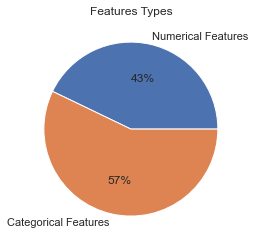

In [8]:
m_describe.show_main(df3,export_notes=False)

I want to predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly by analyzing the following features: 
* Age<br>
* RoomService<br>
* FoodCourt<br>
* ShoppingMall<br>
* Spa<br>
* VRDeck<br>
* PassengerId<br>
* HomePlanet<br>
* CryoSleep<br>
* Cabin<br>
* Destination<br>
* VIP<br>
* Name<br>
 

## Investigating missing values

In [9]:
m_describe.missing_val_list(df1)

,Feature,Type,count of nulls,null % of total obesrvations
0,Age,Numerical,179,2.0
1,RoomService,Numerical,181,2.0
2,FoodCourt,Numerical,183,2.0
3,ShoppingMall,Numerical,208,2.0
4,Spa,Numerical,183,2.0
5,VRDeck,Numerical,188,2.0
6,HomePlanet,Categorical,201,2.0
7,CryoSleep,Categorical,217,2.0
8,Cabin,Categorical,199,2.0
9,Destination,Categorical,182,2.0


In [10]:
m_describe.missing_val_list(df2)

,Feature,Type,count of nulls,null % of total obesrvations
0,Age,Numerical,91,2.0
1,RoomService,Numerical,82,2.0
2,FoodCourt,Numerical,106,2.0
3,ShoppingMall,Numerical,98,2.0
4,Spa,Numerical,101,2.0
5,VRDeck,Numerical,80,2.0
6,HomePlanet,Categorical,87,2.0
7,CryoSleep,Categorical,93,2.0
8,Cabin,Categorical,100,2.0
9,Destination,Categorical,92,2.0


in both training and testing dataset, we have missing values in all features except the predicted value (Transported) which is complete in training dataset, let's examine full dataset features

## Visualizing dataset features

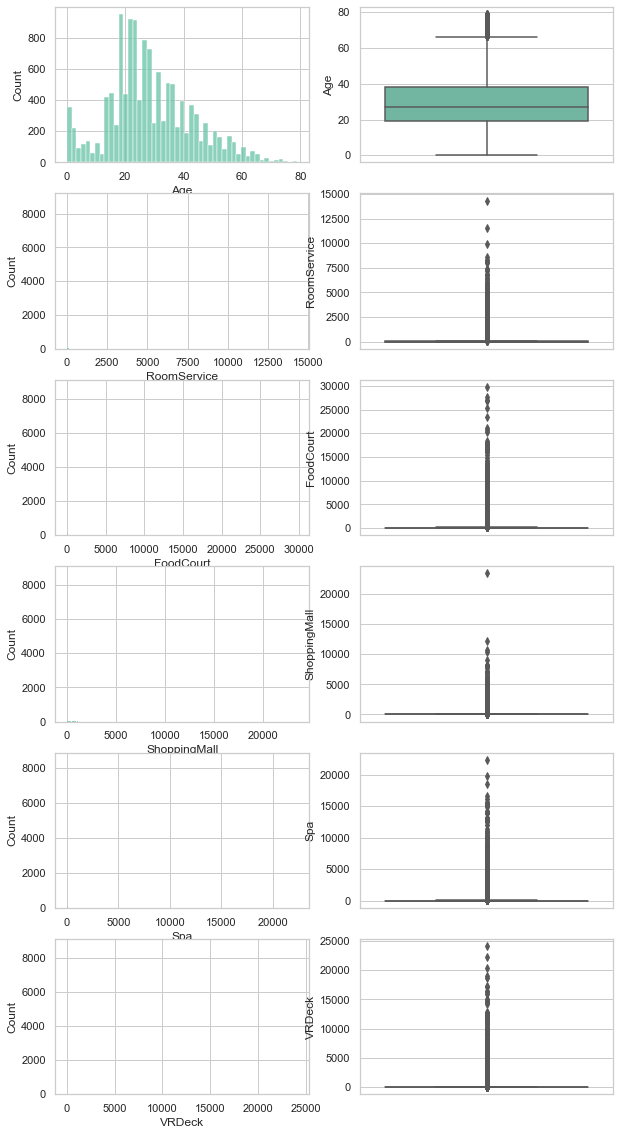

In [12]:
num = m_describe.num(df3)
m_describe.visualize_num(df3,features=num,figure_size=(10,20))

There is something weird in features [RoomService, FoodCourt, ShoppingMall, Spa, VRDeck], let's check values concentration in our dataset. there are very big outliers

In [15]:
m_describe.show_category_concentration(df3,min_percent=0)

,Feature,Unique values,1st category concentration -%
0,VIP,2,98.0
1,CryoSleep,2,64.0
2,Transported,2,50.0
3,Destination,3,70.0
4,HomePlanet,3,54.0
5,Age,80,4.0
6,ShoppingMall,1367,66.0
7,RoomService,1578,65.0
8,VRDeck,1642,65.0
9,Spa,1679,63.0


Yes, in features [RoomService, FoodCourt, ShoppingMall, Spa, VRDeck],63% of values are concentrated on 1 value

In [16]:
df3.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,12700.000000,12707.000000,12681.000000,12664.000000,12686.000000,12702.000000
mean,28.771969,222.897852,451.961675,174.906033,308.476904,306.789482
std,14.387261,647.596664,1584.370747,590.558690,1130.279641,1180.097223
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,49.000000,77.000000,29.000000,57.000000,42.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


I think later i can extract new information from PassengerId and Cabin, but so far let's drop those columns and Name column

In [17]:
df31= df3.copy()
labels=['PassengerId','Cabin','Name','VIP']
df31.drop(labels=labels,axis=1,inplace=True)

Features: [RoomService, FoodCourt, ShoppingMall, Spa, VRDeck] have very big outliers, so for the moment i will neglect those featuers in creating my ML model. Later, I'll check if model accuracy can be improved by adding those features

In [18]:
df32= df31.copy()
labels=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
df32.drop(labels=labels,axis=1,inplace=True)

In [19]:
df32.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12970 entries, 0 to 4276
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   HomePlanet   12682 non-null  object 
 1   CryoSleep    12660 non-null  object 
 2   Destination  12696 non-null  object 
 3   Age          12700 non-null  float64
 4   Transported  8693 non-null   object 
dtypes: float64(1), object(4)
memory usage: 608.0+ KB


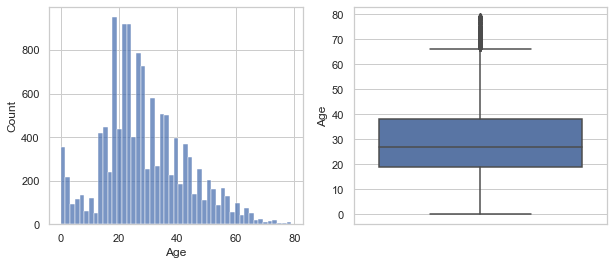

In [20]:
#Exploring numerical features ('Age')
fig, a=plt.subplots(1,2,figsize=(10,4));
sns.histplot(df32['Age'],ax=a[0]);
sns.boxplot(y=df32['Age'],ax=a[1]);

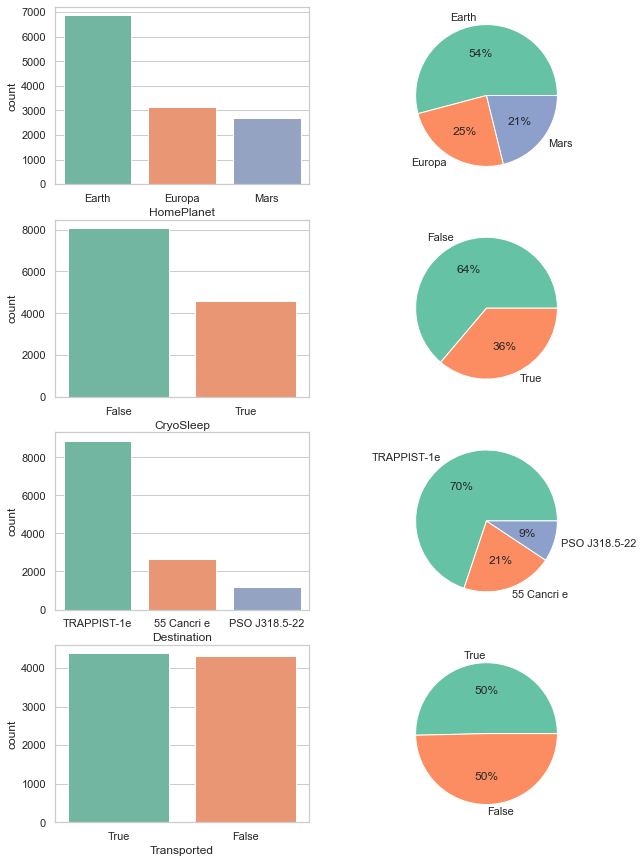

In [21]:
m_describe.visualize_cat(df32,figure_size=(10,15))

# Handling missing values

In [22]:
m_describe.missing_val_list(df32)

,Feature,Type,count of nulls,null % of total obesrvations
0,Age,Numerical,270,2.0
1,HomePlanet,Categorical,288,2.0
2,CryoSleep,Categorical,310,2.0
3,Destination,Categorical,274,2.0
4,Transported,Categorical,4277,33.0


In [23]:
df33=df32.copy()

In [24]:
df33['Age'].fillna(df3['Age'].median(),inplace=True)
df33['HomePlanet'].fillna(df33['HomePlanet'].mode()[0],inplace=True)
df33['CryoSleep'].fillna(df33['CryoSleep'].mode()[0],inplace=True)
df33['Destination'].fillna(df33['Destination'].mode()[0],inplace=True)

# Modelling raw data

In [25]:
#extracting train and test data back

df12=df33.iloc[:8693,:]
df22=df33.iloc[8693:,:]
df22.drop(labels='Transported',axis=1,inplace=True)

In [26]:
df1.shape,df12.shape

((8693, 14), (8693, 5))

In [27]:
df2.shape,df22.shape

((4277, 13), (4277, 4))

In [28]:
cat=m_describe.cat(df22)
num=m_describe.num(df22)

In [29]:
xtr_sc,xts_sc,ytr,yts,dfts_sc= m_scale_encode_split(dftrain=df12,target_feature='Transported',
                                                      num_feature=num,cat_feature=cat,
                                                       train_size=.8,dftest=df12,encode_target=1)

In [30]:
m_mlog_regression(xtr_sc,xts_sc,ytr,yts)

,index,Model,Type,Scaled,Score
0,3,SVC,General,Yes,0.612996
1,5,RandomForest,General,Yes,0.612996
2,4,DecisionTree,General,Yes,0.610696
3,2,GaussianNB,General,Yes,0.608396
4,0,Logistic,General,Yes,0.603795
5,1,Kneighbors,General,Yes,0.576193


so best model so far is SVC

# Feature Engineering / Selection

## Spending features [RoomService, FoodCourt, ShoppingMall, Spa, VRDeck]

### Handling outliers

In [32]:
df35=df31.copy()

In [33]:
#filling missing values by median
#numerical
x=['Age','RoomService','FoodCourt','ShoppingMall', 'Spa', 'VRDeck']
for i in range(len(x)):
    df35[x[i]].fillna(df35[x[i]].median(),inplace=True)

#categorical
x=['HomePlanet','CryoSleep','Destination']
for i in range(len(x)):
    df35[x[i]].fillna(df35[x[i]].mode()[0],inplace=True)

In [34]:
df15=df35.iloc[:8693,:]
features=df15.columns

In [35]:
num=m_describe.num(df15)
print (num)
m_outlier_all(df15,n=0,features=num)

['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
Method IQR:
Total number of outliers is: 1849
Total number of observations containing more than 0 outliers is: 5058 
Percentage of data to be lost is: %58.0

Method Standard deviation:
Total number of outliers is: 166
Total number of observations containing more than 0 outliers is: 756 
Percentage of data to be lost is: %9.0

Method Z-Score:
Total number of outliers is: 166
Total number of observations containing more than 0 outliers is: 756 
Percentage of data to be lost is: %9.0

Method Modified Z-Score:
Total number of outliers is: 8693
Total number of observations containing more than 0 outliers is: 8693 
Percentage of data to be lost is: %100.0

Method Isolation forest:
The total number of outliers is:  637
Percentage of data to be lost is: %7.0

Method DBSCAN:
The total number of clusters without outliers:  9
The number of outliers is:  981
Percentage of data to be lost is: %11.0
--------------------------------

{2,
 11,
 30,
 54,
 70,
 73,
 75,
 105,
 113,
 120,
 140,
 154,
 224,
 230,
 232,
 268,
 275,
 280,
 301,
 316,
 326,
 335,
 336,
 338,
 358,
 359,
 362,
 375,
 379,
 385,
 387,
 401,
 439,
 453,
 474,
 490,
 495,
 496,
 503,
 582,
 636,
 637,
 666,
 707,
 725,
 735,
 764,
 799,
 832,
 844,
 848,
 849,
 857,
 871,
 926,
 928,
 930,
 936,
 983,
 1043,
 1053,
 1057,
 1073,
 1078,
 1094,
 1095,
 1098,
 1133,
 1136,
 1171,
 1177,
 1186,
 1213,
 1222,
 1233,
 1237,
 1341,
 1347,
 1385,
 1389,
 1390,
 1391,
 1436,
 1447,
 1451,
 1459,
 1467,
 1496,
 1562,
 1572,
 1579,
 1595,
 1598,
 1603,
 1666,
 1667,
 1679,
 1701,
 1703,
 1720,
 1725,
 1740,
 1770,
 1782,
 1783,
 1826,
 1831,
 1842,
 1845,
 1886,
 1938,
 1945,
 1947,
 1958,
 1968,
 1980,
 2031,
 2036,
 2067,
 2097,
 2127,
 2130,
 2137,
 2142,
 2143,
 2147,
 2153,
 2158,
 2163,
 2182,
 2207,
 2214,
 2245,
 2310,
 2324,
 2331,
 2334,
 2340,
 2364,
 2406,
 2415,
 2464,
 2468,
 2492,
 2493,
 2499,
 2537,
 2552,
 2604,
 2607,
 2618,
 2647,
 26

In [36]:
drop_index=_
df16=df15.copy()
df16.drop(labels=drop_index,axis=0,inplace=True)
df15.shape,df16.shape

((8693, 10), (8205, 10))

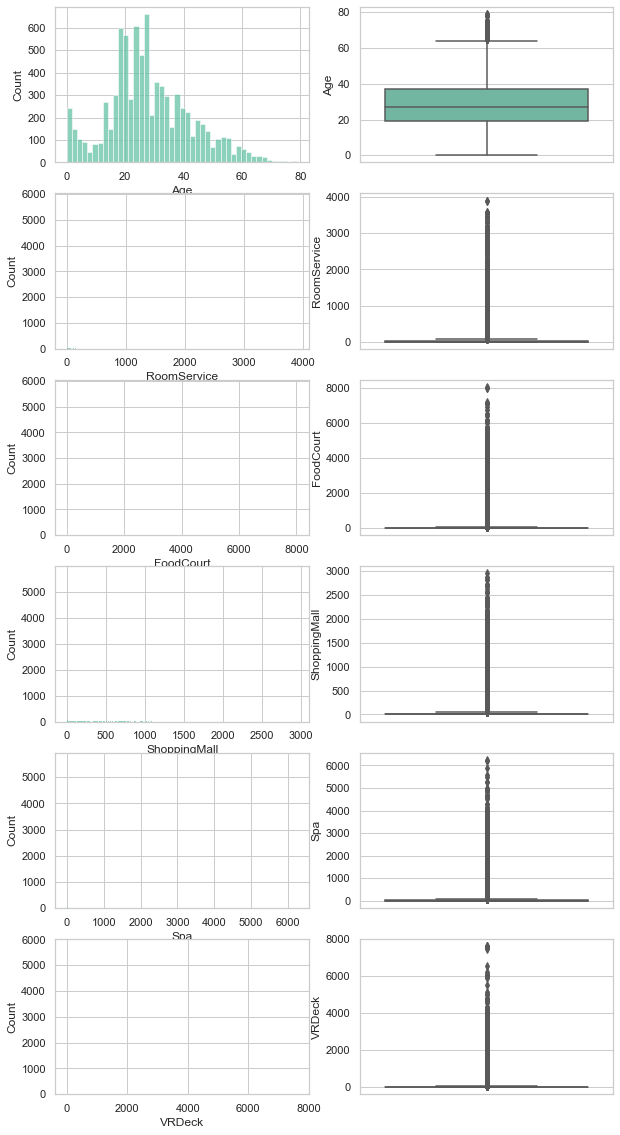

In [37]:
m_describe.visualize_num(df16,features=num,figure_size=(10,20))

In [38]:
m_outlier_all(df16,n=0,features=['RoomService'])

Method IQR:
Total number of outliers is: 1808
Total number of observations containing more than 0 outliers is: 1808 
Percentage of data to be lost is: %22.0

Method Standard deviation:
Total number of outliers is: 230
Total number of observations containing more than 0 outliers is: 230 
Percentage of data to be lost is: %3.0

Method Z-Score:
Total number of outliers is: 230
Total number of observations containing more than 0 outliers is: 230 
Percentage of data to be lost is: %3.0

Method Modified Z-Score:
Total number of outliers is: 8205
Total number of observations containing more than 0 outliers is: 8205 
Percentage of data to be lost is: %100.0

Method Isolation forest:
The total number of outliers is:  2377
Percentage of data to be lost is: %29.0

Method DBSCAN:
The total number of clusters without outliers:  1
The number of outliers is:  2
Percentage of data to be lost is: %0.0
----------------------------------------------------------------------------------------------------
T

set()

In [39]:
m_outlier_std(df16,n=0,features=['RoomService'])

Total number of outliers is: 230
Total number of observations containing more than 0 outliers is: 230 
Percentage of data to be lost is: %3.0


[63,
 99,
 121,
 124,
 155,
 203,
 205,
 231,
 239,
 364,
 404,
 405,
 425,
 464,
 533,
 544,
 559,
 620,
 657,
 658,
 659,
 670,
 680,
 683,
 827,
 847,
 949,
 1027,
 1105,
 1115,
 1193,
 1212,
 1240,
 1244,
 1316,
 1325,
 1424,
 1559,
 1574,
 1609,
 1611,
 1613,
 1659,
 1708,
 1727,
 1729,
 1751,
 1769,
 1798,
 1808,
 1816,
 1959,
 1960,
 1964,
 2016,
 2045,
 2057,
 2058,
 2089,
 2113,
 2228,
 2307,
 2348,
 2366,
 2388,
 2443,
 2456,
 2482,
 2486,
 2511,
 2550,
 2591,
 2646,
 2673,
 2683,
 2752,
 2795,
 2820,
 2827,
 2832,
 2842,
 2880,
 2931,
 2994,
 3020,
 3090,
 3125,
 3170,
 3288,
 3316,
 3446,
 3467,
 3548,
 3588,
 3597,
 3607,
 3663,
 3669,
 3710,
 3747,
 3764,
 3801,
 3815,
 3817,
 3932,
 3974,
 4064,
 4190,
 4202,
 4208,
 4422,
 4430,
 4488,
 4552,
 4565,
 4609,
 4632,
 4657,
 4669,
 4747,
 4764,
 4875,
 4897,
 4961,
 4974,
 5011,
 5037,
 5041,
 5056,
 5057,
 5082,
 5119,
 5198,
 5212,
 5285,
 5287,
 5321,
 5365,
 5457,
 5572,
 5590,
 5617,
 5701,
 5706,
 5717,
 5730,
 5812,


In [40]:
drop_index=_
df16=df15.copy()
df16.drop(labels=drop_index,axis=0,inplace=True)
df15.shape,df16.shape

((8693, 10), (8463, 10))

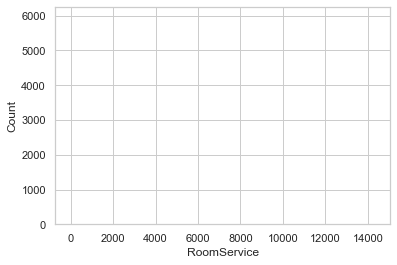

In [41]:
sns.histplot(df16['RoomService']);

In [43]:
print (df15[(df15['RoomService']==0)]['RoomService'].count()/df15.shape[0]*100)
print (df15[(df15['FoodCourt']==0)]['FoodCourt'].count()/df15.shape[0]*100)
print (df15[(df15['ShoppingMall']==0)]['ShoppingMall'].count()/df15.shape[0]*100)
print (df15[(df15['Spa']==0)]['Spa'].count()/df15.shape[0]*100)
print (df15[(df15['VRDeck']==0)]['VRDeck'].count()/df15.shape[0]*100)

66.23720234671575
64.86828482687218
66.66283216380997
63.34982169561716
65.3744392039572


**Interesting fact, >64% of all passengers didn't spend money on spaceship, we can classify them into two categories by spend and not spend**

### Labeling

In [44]:
df36=df35.copy()

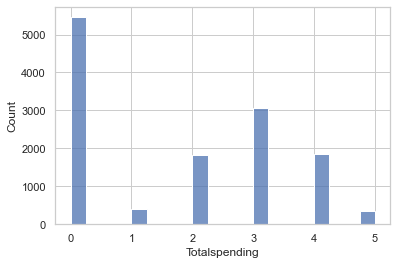

In [45]:
#classifying spending columns to be 1 if more than 0 and 0 of spending is 0
df36['RoomService']= df36['RoomService'].map(lambda x: 1 if x>0 else 0)
df36['FoodCourt']= df36['FoodCourt'].map(lambda x: 1 if x>0 else 0)
df36['ShoppingMall']= df36['ShoppingMall'].map(lambda x: 1 if x>0 else 0)
df36['Spa']= df36['Spa'].map(lambda x: 1 if x>0 else 0)
df36['VRDeck']= df36['VRDeck'].map(lambda x: 1 if x>0 else 0)
#exploring if there are passengers can spend on some features and not on any other features
df36['Totalspending']=df36['RoomService']+df36['FoodCourt']+df36['ShoppingMall']+df36['Spa']+df36['VRDeck']
sns.histplot(df36['Totalspending']);

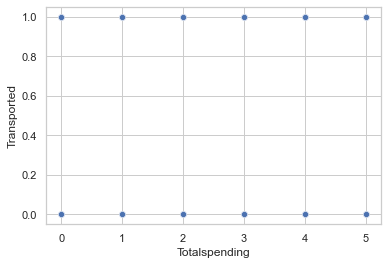

In [46]:
sns.scatterplot(df36['Totalspending'],df36['Transported']);

### Remodelling

In [47]:
#extracting train and test data back

df12=df36.iloc[:8693,:]
df22=df36.iloc[8693:,:]
df22.drop(labels='Transported',axis=1,inplace=True)

In [48]:
df1.shape,df12.shape

((8693, 14), (8693, 11))

In [49]:
df2.shape,df22.shape

((4277, 13), (4277, 10))

In [50]:
cat=m_describe.cat(df22)
num=m_describe.num(df22)

In [51]:
xtr_sc,xts_sc,ytr,yts,dfts_sc= m_scale_encode_split(dftrain=df12,target_feature='Transported',
                                                      num_feature=num,cat_feature=cat,
                                                       train_size=.8,dftest=df12,encode_target=1)

In [52]:
m_mlog_regression(xtr_sc,xts_sc,ytr,yts)

,index,Model,Type,Scaled,Score
0,3,SVC,General,Yes,0.736630
1,0,Logistic,General,Yes,0.730880
2,2,GaussianNB,General,Yes,0.730880
3,1,Kneighbors,General,Yes,0.700403
4,4,DecisionTree,General,Yes,0.689477
5,5,RandomForest,General,Yes,0.680851


Wow, my model improved very much by including spending features

## PassengerId


### Extracting new features

In [53]:
df3[['PassengerId','Cabin','VIP']].head(5)

,PassengerId,Cabin,VIP
0,0001_01,B/0/P,False
1,0002_01,F/0/S,False
2,0003_01,A/0/S,True
3,0003_02,A/0/S,False
4,0004_01,F/1/S,False


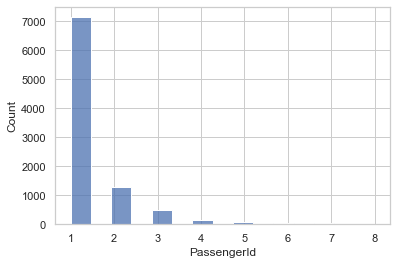

In [54]:
#PassengerId
sns.histplot(df3['PassengerId'].str[0:4].value_counts());

In [55]:
df37=df36.copy()

In [56]:
df3['PassengerId'].str[0:4].head(5)

0    0001
1    0002
2    0003
3    0003
4    0004
Name: PassengerId, dtype: object

In [57]:
df37['HasFamily']=df3['PassengerId'].str[0:4]

In [58]:
value_counts = df37['HasFamily'].value_counts().to_dict()
# replace the values in column 'A' with their counts
df37['HasFamily'] = df37['HasFamily'].map(value_counts)
df37['HasFamily'] = df37['HasFamily'].map(lambda x: 1 if x>1 else 0)

### Remodelling

In [59]:
#extracting train and test data back

df12=df37.iloc[:8693,:]
df22=df37.iloc[8693:,:]
df22.drop(labels='Transported',axis=1,inplace=True)

In [60]:
df1.shape,df12.shape

((8693, 14), (8693, 12))

In [61]:
df2.shape,df22.shape

((4277, 13), (4277, 11))

In [62]:
#changing binary features into categorical
cat_list=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck','HasFamily']
for i in range (len(cat_list)):
    df22[cat_list[i]]=df22[cat_list[i]].astype('object')


In [63]:
cat=m_describe.cat(df22)
num=m_describe.num(df22)

In [64]:
cat

['HomePlanet',
 'Destination',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck',
 'HasFamily']

In [65]:
xtr_sc,xts_sc,ytr,yts,dfts_sc= m_scale_encode_split(dftrain=df12,target_feature='Transported',
                                                      num_feature=num,cat_feature=cat,
                                                       train_size=.8,dftest=df12,encode_target=1)

In [66]:
m_mlog_regression(xtr_sc,xts_sc,ytr,yts)

,index,Model,Type,Scaled,Score
0,3,SVC,General,Yes,0.742956
1,0,Logistic,General,Yes,0.732030
2,2,GaussianNB,General,Yes,0.722829
3,1,Kneighbors,General,Yes,0.705578
4,5,RandomForest,General,Yes,0.673376
5,4,DecisionTree,General,Yes,0.660150


it didn't improve very much considering if passenger has family or not in Titan spaceship

## Cabin

### Extracting new features

In [67]:
#Cabin
x = pd.DataFrame()
x['Deck']=df3['Cabin'].str[0]
x['Num']=df3['Cabin'].str.extract(r'/(.+?)/')
x['Side']=df3['Cabin'].str[-1]

In [68]:
print (x['Deck'].nunique()) ,print (x['Deck'].value_counts())
print (x['Num'].nunique()) ,print (x['Num'].value_counts())
print (x['Side'].nunique()) ,print (x['Side'].value_counts())

8
F    4239
G    3781
E    1323
B    1141
C    1102
D     720
A     354
T      11
Name: Deck, dtype: int64
1894
82      34
4       28
56      28
95      27
31      27
        ..
1848     1
1847     1
1846     1
1844     1
1890     1
Name: Num, Length: 1894, dtype: int64
2
S    6381
P    6290
Name: Side, dtype: int64


(None, None)

Based on the number of unique values of Deck, Number and side, I guess the most important feauters are Deck and Side

In [69]:
df38=df37.copy()

In [70]:
df38['Deck']=x['Deck']
df38['Side']=x['Side']
df38.head(5)

,HomePlanet,CryoSleep,Destination,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Totalspending,HasFamily,Deck,Side
0,Europa,False,TRAPPIST-1e,39.0,0,0,0,0,0,False,0,0,B,P
1,Earth,False,TRAPPIST-1e,24.0,1,1,1,1,1,True,5,0,F,S
2,Europa,False,TRAPPIST-1e,58.0,1,1,0,1,1,False,4,1,A,S
3,Europa,False,TRAPPIST-1e,33.0,0,1,1,1,1,False,4,1,A,S
4,Earth,False,TRAPPIST-1e,16.0,1,1,1,1,1,True,5,0,F,S


In [71]:
m_describe.missing_val_list(df38)

,Feature,Type,count of nulls,null % of total obesrvations
0,Transported,Categorical,4277,33.0
1,Deck,Categorical,299,2.0
2,Side,Categorical,299,2.0


Let's fill missing values in Deck and Side

In [72]:
df38['Deck'].fillna(df38['Deck'].mode()[0],inplace=True)
df38['Side'].fillna(df38['Side'].mode()[0],inplace=True)

### Remodelling

In [73]:
#extracting train and test data back

df12=df38.iloc[:8693,:]
df22=df38.iloc[8693:,:]
df22.drop(labels='Transported',axis=1,inplace=True)

In [74]:
df1.shape,df12.shape

((8693, 14), (8693, 14))

In [75]:
df2.shape,df22.shape

((4277, 13), (4277, 13))

In [76]:
#changing binary features into categorical
cat_list=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck','HasFamily']
for i in range (len(cat_list)):
    df22[cat_list[i]]=df22[cat_list[i]].astype('object')


In [77]:
cat=m_describe.cat(df22)
num=m_describe.num(df22)

In [78]:
num

['Age', 'Totalspending']

In [79]:
xtr_sc,xts_sc,ytr,yts,dfts_sc= m_scale_encode_split(dftrain=df12,target_feature='Transported',
                                                      num_feature=num,cat_feature=cat,
                                                       train_size=.8,dftest=df12,encode_target=1)

In [80]:
m_mlog_regression(xtr_sc,xts_sc,ytr,yts)

,index,Model,Type,Scaled,Score
0,3,SVC,General,Yes,0.763082
1,0,Logistic,General,Yes,0.730305
2,2,GaussianNB,General,Yes,0.726855
3,1,Kneighbors,General,Yes,0.720529
4,5,RandomForest,General,Yes,0.698677
5,4,DecisionTree,General,Yes,0.680851


Adding cabin feautes, didn't improve our model accuracy

## VIP

### Feature engineering

In [81]:
#VIP
df39 = df37.copy()

In [82]:
df39['VIP']=df3['VIP']

In [83]:
#filling missing values
df39['VIP'].isnull().sum()

296

In [84]:
df39['VIP'].fillna(df39['VIP'].mode()[0],inplace=True)

### Remodelling

In [85]:
#extracting train and test data back

df12=df39.iloc[:8693,:]
df22=df39.iloc[8693:,:]
df22.drop(labels='Transported',axis=1,inplace=True)

In [86]:
df1.shape,df12.shape

((8693, 14), (8693, 13))

In [87]:
df2.shape,df22.shape

((4277, 13), (4277, 12))

In [88]:
#changing binary features into categorical
cat_list=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck','HasFamily']
for i in range (len(cat_list)):
    df22[cat_list[i]]=df22[cat_list[i]].astype('object')


In [89]:
cat=m_describe.cat(df22)
num=m_describe.num(df22)

In [90]:
num

['Age', 'Totalspending']

In [91]:
xtr_sc,xts_sc,ytr,yts,dfts_sc= m_scale_encode_split(dftrain=df12,target_feature='Transported',
                                                      num_feature=num,cat_feature=cat,
                                                       train_size=.8,dftest=df12,encode_target=1)

In [92]:
m_mlog_regression(xtr_sc,xts_sc,ytr,yts)

,index,Model,Type,Scaled,Score
0,3,SVC,General,Yes,0.740081
1,2,GaussianNB,General,Yes,0.728580
2,0,Logistic,General,Yes,0.726279
3,1,Kneighbors,General,Yes,0.697527
4,5,RandomForest,General,Yes,0.683151
5,4,DecisionTree,General,Yes,0.679701


Also VIP feature didn't improve our model, so my best model so far has the following features: 

In [93]:
df33.columns

Index(['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'Transported'], dtype='object')

In [94]:
df37.columns

Index(['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'RoomService',
       'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Transported',
       'Totalspending', 'HasFamily'],
      dtype='object')

In [95]:
df37

,HomePlanet,CryoSleep,Destination,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Totalspending,HasFamily
0,Europa,False,TRAPPIST-1e,39.0,0,0,0,0,0,False,0,0
1,Earth,False,TRAPPIST-1e,24.0,1,1,1,1,1,True,5,0
2,Europa,False,TRAPPIST-1e,58.0,1,1,0,1,1,False,4,1
3,Europa,False,TRAPPIST-1e,33.0,0,1,1,1,1,False,4,1
4,Earth,False,TRAPPIST-1e,16.0,1,1,1,1,1,True,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4272,Earth,True,TRAPPIST-1e,34.0,0,0,0,0,0,NaN,0,1
4273,Earth,False,TRAPPIST-1e,42.0,0,1,1,1,1,NaN,4,0
4274,Mars,True,55 Cancri e,27.0,0,0,0,0,0,NaN,0,0
4275,Europa,False,TRAPPIST-1e,27.0,0,1,0,0,1,NaN,2,0


# Modelling full data

In [348]:
df34=df37.copy()

In [351]:
#changing binary features into categorical
cat_list=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck','HasFamily','CryoSleep']
for i in range (len(cat_list)):
    df34[cat_list[i]]=df34[cat_list[i]].astype('object')

In [354]:
m_describe.num(df34),m_describe.cat(df34)

(['Age', 'Totalspending'],
 ['HomePlanet',
  'CryoSleep',
  'Destination',
  'RoomService',
  'FoodCourt',
  'ShoppingMall',
  'Spa',
  'VRDeck',
  'Transported',
  'HasFamily'])

In [355]:
df34=pd.get_dummies(df34,drop_first=True)

In [356]:
sc=StandardScaler()
df34['Age']=sc.fit_transform(df34[['Age']])

In [357]:
#training data
df34_1= df34.iloc[:8693,:]
#testing data
df34_2= df34.iloc[8693:,]

df34_1.shape,df34_2.shape

((8693, 14), (4277, 14))

In [358]:
xtr=df34_1.copy()
xtr.drop(labels='Transported_True',axis=1,inplace=True)
ytr=df34_1['Transported_True']

xts=df34_2.copy()
xts.drop(labels='Transported_True',axis=1,inplace=True)

In [359]:
xtr.shape,ytr.shape,xts.shape

((8693, 13), (8693,), (4277, 13))

In [360]:
model=SVC()

In [361]:
model.fit(xtr,ytr)
ypr=model.predict(xts)

In [362]:
df2_final=df2.copy()
df2_final['Transported']=ypr

In [363]:
submission_name='submission2.csv'
df2_final[['PassengerId','Transported']].to_csv(submission_name,index=False)